In [3]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_mri_seg'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import scipy.ndimage.interpolation as interpol

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import HVSMR2016CardiacMRI
from config.config import config
from utils.img_sampling import resample_image_scipy
from in_out.read_save_images import save_img_as_mhg

from in_out.load_data import load_mhd_to_numpy


# from utils.experiment import Experiment
# from utils.batch_handlers import TwoDimBatchHandler

# from models.dilated_cnn import BaseDilated2DCNN

# from jelmer_util.helper import loadImageDir, generateBatch2D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
dataset = HVSMR2016CardiacMRI(data_dir=config.data_dir, search_mask=config.dflt_image_name + ".nii",
                              norm_scale="normalize", load_type="raw")

> > > Loading image+label from /home/jogi/git/repository/dcnn_mri_seg/data/HVSMR2016/train/0_image.nii
> > > Info - Normalizing images intensity values
('Before ', 710.77777)
('After ', -1.5138708e-07)
/home/jogi/git/repository/dcnn_mri_seg/data/HVSMR2016/train/0_image.nii / /home/jogi/git/repository/dcnn_mri_seg/data/HVSMR2016/train/0_label.nii


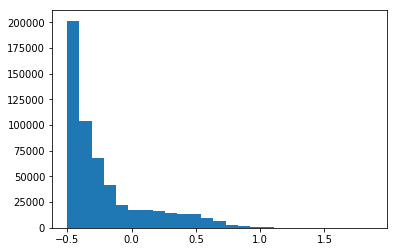

In [4]:
in_filename = "/home/jorg/repository/dcnn_acdc/data/Folds/fold1/train/images/patient001_frame01.mhd"
# in_filename = "/home/jorg/repository/dcnn_mri_seg/data/HVSMR2016/train/0_image.nii"
mri_scan, origin, spacing = load_mhd_to_numpy(in_filename, data_type="float32", swap_axis=True)

plt.hist(mri_scan.flatten(), bins=25)
plt.show()

Before  (216, 256, 10) [  1.5625   1.5625  10.    ]
After  (241, 286, 10) (1.1160714285714286, 1.1160714285714286, 1)


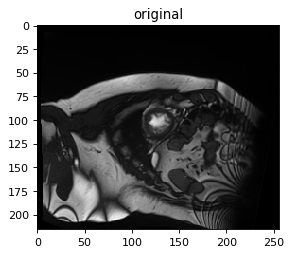

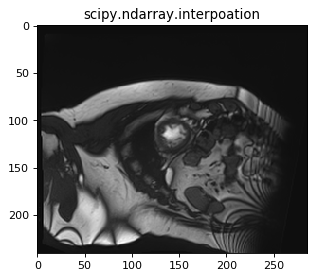

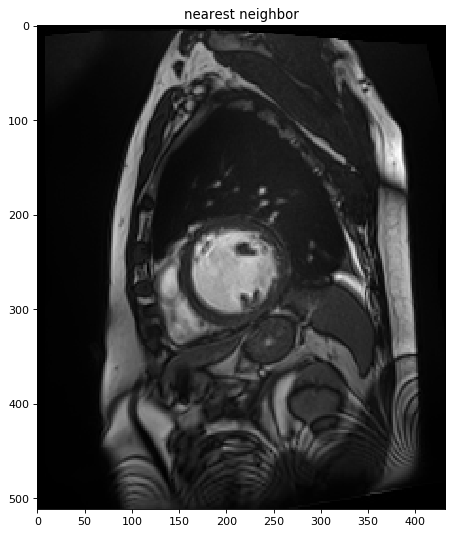

In [ ]:
in_filename = "/home/jorg/repository/dcnn_acdc/data/Folds/fold1/train/images/patient001_frame01.mhd"
# in_filename = "/home/jorg/repository/dcnn_mri_seg/data/HVSMR2016/train/0_image.nii"
mri_scan, origin, spacing = load_mhd_to_numpy(in_filename, data_type="float32", swap_axis=True)
new_voxel_spacing = 1.4

new_spacing = tuple((spacing[0] / new_voxel_spacing,
                                 spacing[1] / new_voxel_spacing, 1))
print("Before ", mri_scan.shape, spacing)

image = interpol.zoom(mri_scan, (new_spacing[0], new_spacing[1], new_spacing[2]), order=3)

print("After ", image.shape, new_spacing)

idx = 9
# image = sitk.GetImageFromArray(mri_scan[5])
myshow(mri_scan[:, :, idx], title="original")
myshow(image[:, :, idx], title="scipy.ndarray.interpoation")

mri_scan = np.swapaxes(mri_scan, 0, 2)
itkimage = sitk.GetImageFromArray(mri_scan)
img1 = sitk.Expand(itkimage, [2]*3, sitk.sitkNearestNeighbor)
# img2 = sitk.Expand(itkimage, [2]*3, sitk.sitkLinear)
# sitk.Expand(itkimage, new_spacing, sitk.sitkBSpline), title="b-spline")
# sitk.Expand(itkimage, new_spacing, sitk.sitkGaussian), title="Gaussian")
img1 = sitk.GetArrayViewFromImage(img1)
myshow(img1[idx], title="nearest neighbor")
del img1
img2 = sitk.Expand(itkimage, [2]*3, sitk.sitkLinear)
img2 = sitk.GetArrayViewFromImage(img2)
del mri_scan
del image
myshow(img2[idx], title="linear")

In [1]:
def myshow(img, title=None, margin=0.05):
    
    xsize, ysize = img.shape

    dpi=80
    
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1+margin)*ysize / dpi, (1+margin)*xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    t = ax.imshow(img)
    if len(img.shape) == 2:
        t.set_cmap("gray")
    if(title):
        plt.title(title)
    plt.show()